### grid generation

<b>requirements:</b>
<ul>
    <li>numpy</li>
    <li>...</li>
</ul>


In [1]:
print('hey there')

hey there


In [1]:
print('!!! ALIYA PRIVET')

!!! ALIYA PRIVET


In [2]:
def generate_nodes(**kwargs):
    """"""
    import matplotlib.pyplot as plt
    import matplotlib.patches
    import numpy as np

    el = matplotlib.patches.Ellipse((50,-23), 10, 13.7, 20, facecolor=(1,0,0,.2), edgecolor='none')

    y_int = np.arange(-30, -15)
    x_int = np.arange(40, 60)

    g = np.meshgrid(x_int, y_int)
    coords = list(zip(*(c.flat for c in g)))

    ellipsepoints = np.vstack([p for p in coords if el.contains_point(p, radius=0)])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.add_artist(el)
    ep = np.array(ellipsepoints)
    ax.plot(ellipsepoints[:,0], ellipsepoints[:,1], 'go')
    plt.ylim(-31, -15)
    plt.grid()
    plt.show()

    return ellipsepoints

def generate_clusters(ellipsepoints):
    from sklearn.cluster import KMeans
    from collections import defaultdict
    kmeans = KMeans(n_clusters=5, random_state=666)
    kmeans.fit(ellipsepoints)
    labels = kmeans.labels_
    new_grids = defaultdict(list)
    for i, label in enumerate(labels):
        new_grids[label].append(list(ellipsepoints[i]))
        
    return new_grids

def plot_new_grids(new_grids):
    import matplotlib.pyplot as plt
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    for key, value in new_grids.items():
        x_list, y_list = [], []

        for x, y in value:
            x_list.append(x)
            y_list.append(y)

        plt.grid()
        plt.plot(x_list,y_list, f'{colors[key]}o')
        
    return 'Done'

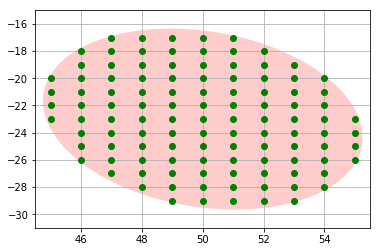

In [6]:
ellipsepoints = generate_nodes()

In [7]:
new_grids = generate_clusters(ellipsepoints)

'Done'

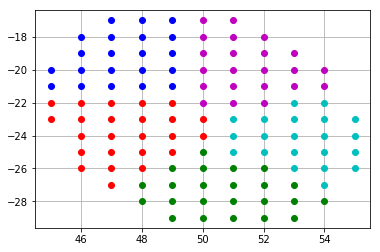

In [8]:
plot_new_grids(new_grids)

### ga

<b>requirements:</b>
<ul>
    <li>mlrose</li>
    <li>...</li>
</ul>


In [14]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [23]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness
    
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route    

    
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

#     child = childP1 + childP2
    child = childP2[:startGene] + childP1 + childP2[startGene:]
    return child

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.grid()
    plt.show()

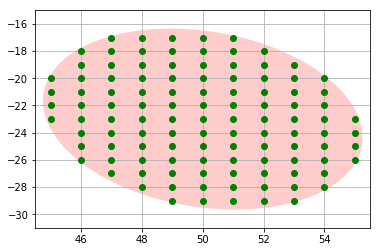

In [46]:
ellipsepoints = generate_nodes()

In [36]:
nodes_list = [City(x=x, y=y) for x, y in ellipsepoints]

In [44]:
route1 = geneticAlgorithm(population=nodes_list, popSize=50, eliteSize=20, mutationRate=0.01, generations=30)

Initial distance: 564.7174628952221
Final distance: 472.3464845710155


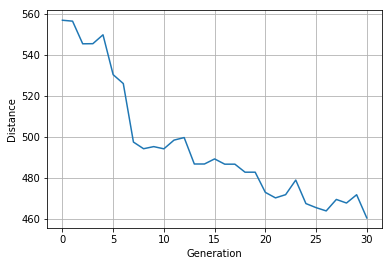

In [43]:
geneticAlgorithmPlot(population=nodes_list, popSize=50, eliteSize=20, mutationRate=0.01, generations=30)

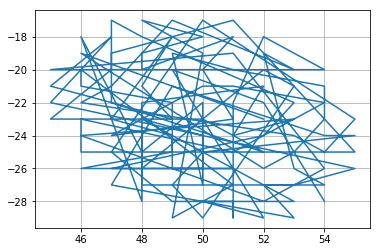

In [45]:
xx = [point.x for point in route1]
yy = [point.y for point in route1]
plt.plot(xx,yy)
plt.grid()